In [1]:
# Load in the required Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
from IPython.display import display 

In [2]:
# Load data 
ticker = 'spy'
df = yf.Ticker(ticker).history(start = '2010-01-01')
df.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,88.469575,89.272624,87.792491,89.225388,118944600
2010-01-05,89.170302,89.500969,88.847503,89.461601,111579900
2010-01-06,89.375007,89.745042,89.304152,89.524597,116074400
2010-01-07,89.359230,90.012696,89.107293,89.902473,131091100
2010-01-08,89.666307,90.241043,89.485230,90.201675,126402800


In [3]:
# Define a function to aggregate the data.  
def agg_data(df, period):
        df = df.copy()
        if period == 'D':
                return df
        else: 
                out= df.resample(period).agg({
                'Open': lambda s: s[0],
                'High': lambda df: df.max(),
                'Low': lambda df: df.min(),
                'Close': lambda df: df[-1],
                'Volume': lambda df: df.sum()})
                return out

y = agg_data(df, 'W')['Close']
print('The length of the data is --> ',len(y))
print('NA\'s present ---> ',y.isna().sum())

The length of the data is -->  661
NA's present --->  0


In [4]:
# Supress FutureWarning Timestamp.freqstr is deprecated .... 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the Theta Forecaster (Simple Exponential Moving Average)
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Now lets apply some Forecasting Methods 
1. `Thetaforecaster`(alpha, deaseasonalize = True, number of seasonal periods = 1): 
   1. simple exponential moving average with a drift 
   2. uses multiplicative decompostition 

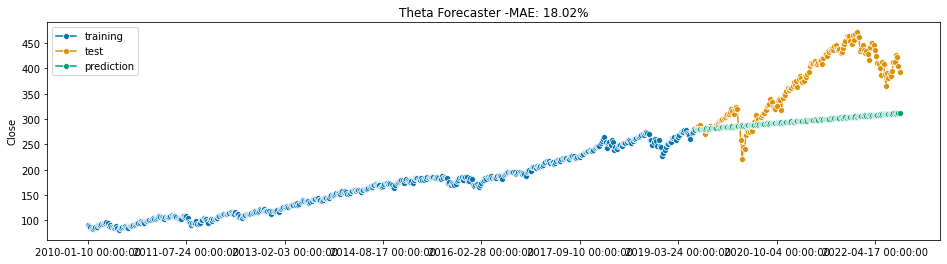

In [5]:
temp_y = y.asfreq('W').bfill().dropna().copy()
y_train, y_test = temporal_train_test_split(temp_y)
fh = ForecastingHorizon(y_test.index, is_relative=False,)


forecaster = ThetaForecaster(sp=4)  # Set periodicity 
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
fig = plot_series(y_train, y_test, y_pred, labels = ['training', 'test', 'prediction'])
figt = plt.title(label = f'Theta Forecaster -MAE: {mean_absolute_percentage_error(y_test, y_pred):.2%}')

2. `NaiveForecaster`: Forecast based on naive assumptions about past trends continuing.
   1. The `NaiveForecaster` can also be used for multivariate data and it then applies internally the `ColumnEnsembleForecaster` 
      1. so each column is forecasted with the same strategy.
   2. __Parameters__:
      1. `strategy` {“last”, “mean”, “drift”}, default=”last”
         1. Strategy used to make forecasts: 
            1. `“last”`: (robust against NaN values) forecast the last value in the training series when sp is 1.
               1.  When sp is not 1, last value of each season in the last window will be forecasted for each season.
            2. `“mean”`: (robust against NaN values)
               1. forecast the mean of last window of training series when sp is 1.
               2.  When sp is not 1, mean of all values in a season from last window will be forecasted for each season.
            3. `“drift”`: (not robust against NaN values)
               1. forecast by fitting a line between the first and last point of the window and extrapolating it into the future.
      2. `sp` = `int`, default=1
         1. Seasonal periodicity to use in the seasonal forecasting.
      3. `window_length` = `int` or None, default=None
         1. Window length to use in the mean strategy. If None, entire training series will be used.

Future Predictions:


2022-09-11    427.100006
2022-09-18    422.140015
2022-09-25    405.309998
Name: Close, dtype: float64

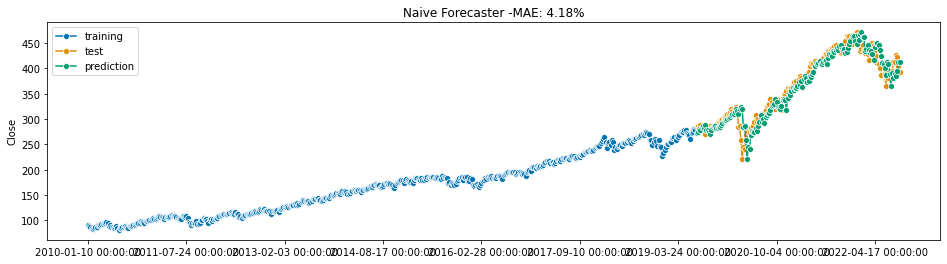

In [6]:
# Import the NaiveForecaster 
from sktime.forecasting.naive import NaiveForecaster
# Set the forecaster with seasonal periods. 
forecaster = NaiveForecaster(strategy="last", sp = 4)
# Define the data 
temp_y = y.asfreq('W').bfill().dropna().copy()
y_train, y_test = temporal_train_test_split(temp_y)
fh = ForecastingHorizon(y_test.index, is_relative=False,)
# Fit the forecaster 
forecaster.fit(temp_y) # Needs to fit the full Y because it uses the last value 
y_pred = forecaster.predict(fh)
fig = plot_series(y_train, y_test, y_pred, labels = ['training', 'test', 'prediction'])
figt = plt.title(label = f'Naive Forecaster -MAE: {mean_absolute_percentage_error(y_test, y_pred):.2%}')
# Get some future predictions
future_preds = forecaster.fit_predict(y, fh = [1,2,3])
print('Future Predictions:')
display(future_preds)

In [7]:
mean_absolute_percentage_error(y_test, y_pred)

0.04181507680956502

3. `ExponentialSmoothing` Method, AKA Holt-Winters Exponential Smoothing Forecaster 
   1. `trend`: trend type of the componenet, can be `add`, `mul`, `additive`,`multiplicative`, or `None`
   2. `damped_trend`: T or F
   3. `seasonal`: same as trend, this denotes the seasonal component. 
   4. `sp`: Number of seasonal Periods
   5. `initial_level`: $\alpha$ level in Holt winters
      1. Lower $\alpha$ is more reactive 
      2. Higer $\alpha$ is less reactive and more like a moving average
   6. `initial_trend`: $\beta$ level in Holt Winters
   7. `initial_seasonal`: $\gamma$ (gamma) level in Holt winters. 


_In order to set the alpha, beta, and gamma levels you must set the `initialization_method` = 'known', Otherwise the parameters are estimated_

In [8]:
temp_y = y.asfreq('D').bfill().dropna().copy()
y_train, y_test = temporal_train_test_split(temp_y)
len(y_test.index)

1156

Future Predictions:


2022-09-11    392.536982
2022-09-18    394.673864
2022-09-25    395.893844
Freq: W-SUN, dtype: float64

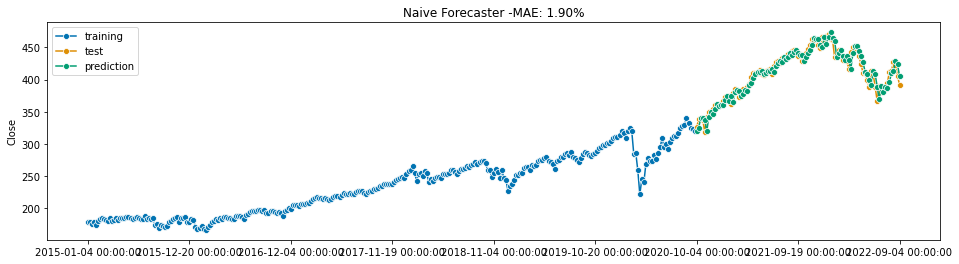

In [9]:
# Import the Exponential Smoothing Forecaster 
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# Set the forecaster with seasonal periods.
forecaster = ExponentialSmoothing(trend= 'additive', seasonal= 'multiplicative', sp= 4)
# Define the data
temp_y = y['2015-01-01':]
y_train, y_test = temporal_train_test_split(temp_y)
fh = ForecastingHorizon(y_test.index, is_relative=False,)
forecaster.fit(y) # Needs to fit the full Y because it uses the last value 
y_pred = forecaster.predict(fh)
fig = plot_series(y_train, y_test, y_pred, labels = ['training', 'test', 'prediction'])
figt = plt.title(label = f'Naive Forecaster -MAE: {mean_absolute_percentage_error(y_test, y_pred):.2%}')

# Get some future predictions
future_preds = forecaster.fit_predict(y, fh = [1,2,3])
print('Future Predictions:')
display(future_preds)

#### Lets test some of the previous split methods above on the forecasting methods we have here. 

1. Using the `SlidingWindowSplitter`